Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 167s 7s/step - accuracy: 0.9145 - loss: 0.3379 - val_accuracy: 0.9820 - val_loss: 0.1199
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 168s 7s/step - accuracy: 0.9832 - loss: 0.1073 - val_accuracy: 0.9820 - val_loss: 0.1013
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 173s 7s/step - accuracy: 0.9836 - loss: 0.0925 - val_accuracy: 0.9820 - val_loss: 0.0929
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 183s 7s/step - accuracy: 0.9838 - loss: 0.0850 - val_accuracy: 0.9820 - val_loss: 0.0892
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 194s 8s/step - accuracy: 0.9838 - loss: 0.0818 - val_accuracy: 0.9820 - val_loss: 0.0904
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 173s 7s/step - accuracy: 0.9839 - loss: 0.0800 - val_accuracy: 0.9820 - val_loss: 0.0869
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 177s 7s/step - accuracy: 0.9834 - loss: 0.0809 - val_accuracy: 0.9820 - val_loss: 0.0860
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 185s 7s/step - accuracy: 0.9837 - loss: 0.0776 - val_accuracy: 0.9820 - v

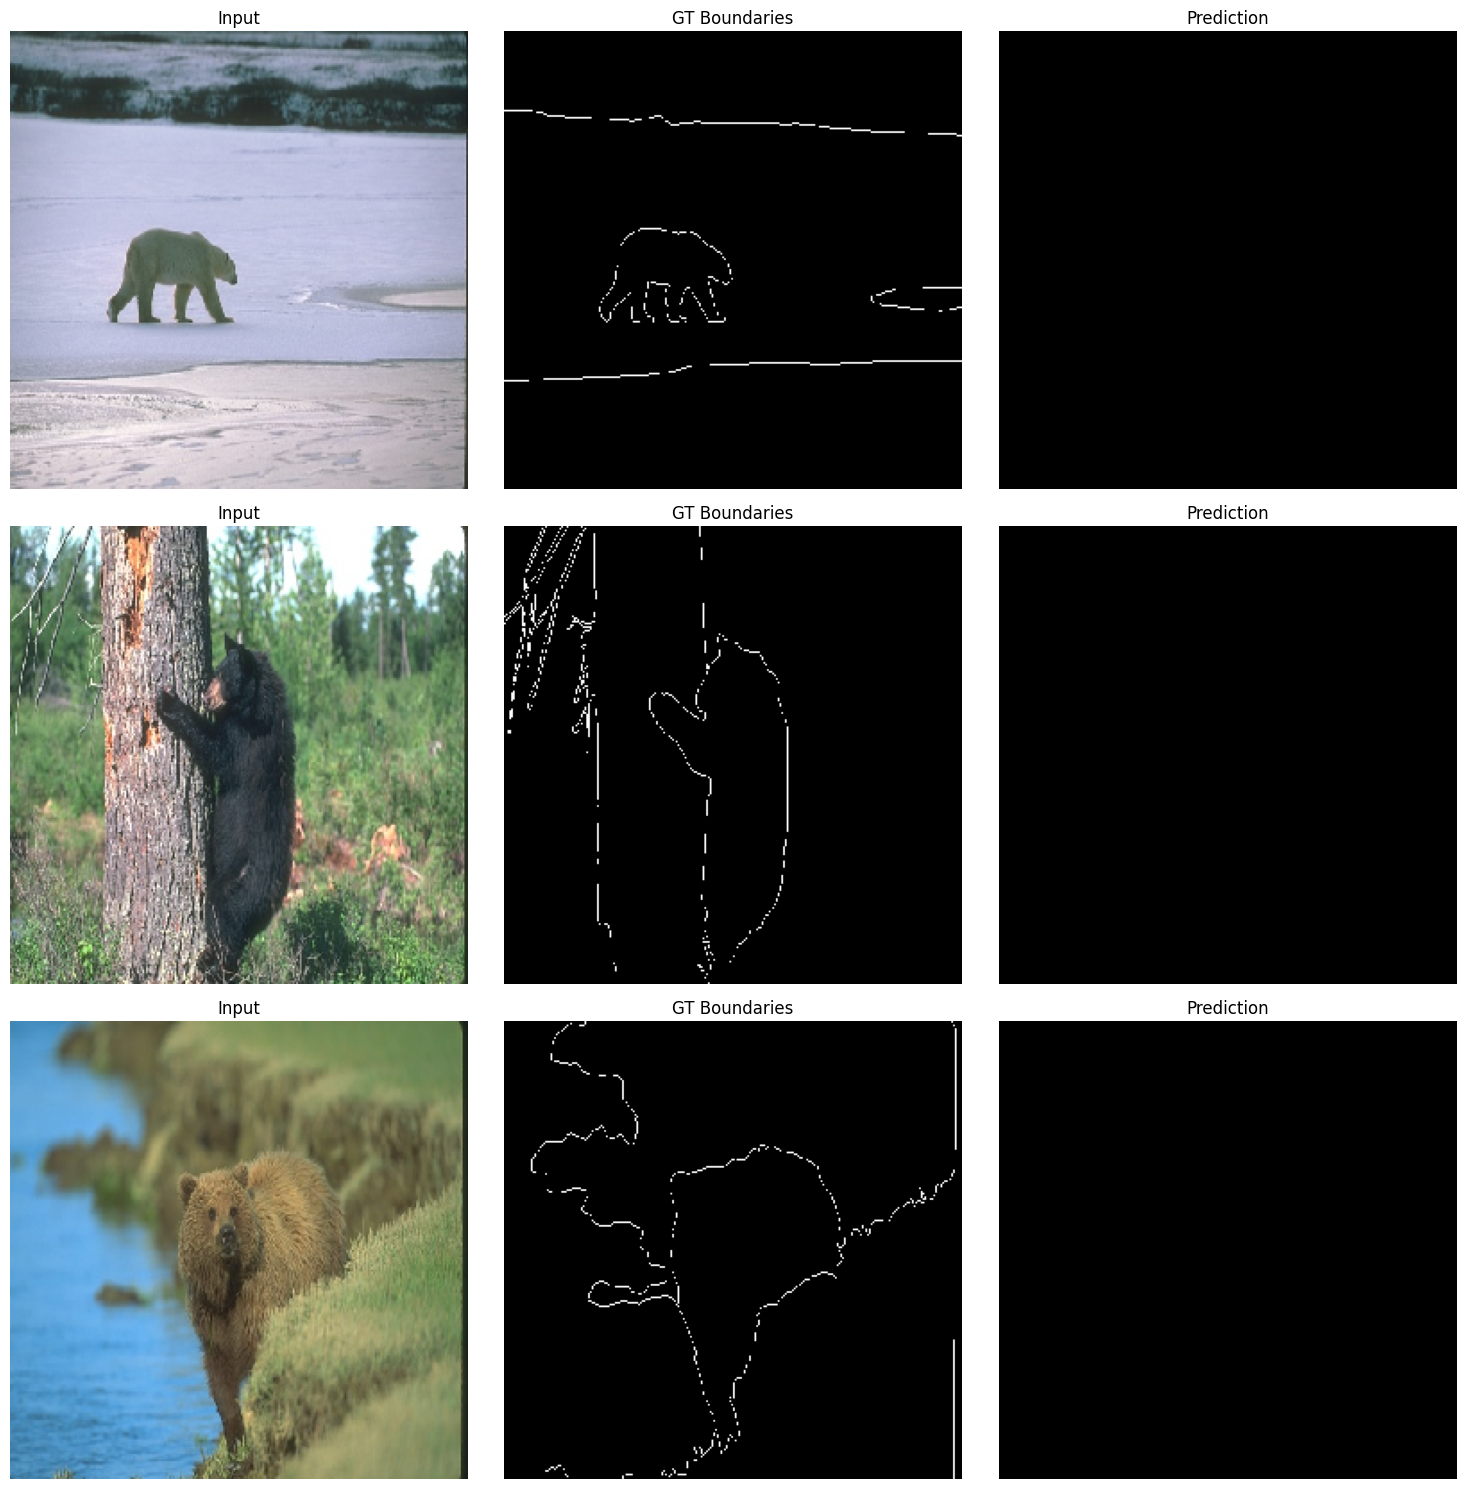

In [31]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img
import scipy.io
import matplotlib.pyplot as plt

# ─── Configuration ────────────────────────────────────────────────────────────
DATA_PATH  = "E:/Downloads/archive (3)/"   # ← your BSDS500 folder
BATCH_SIZE = 8
EPOCHS     = 10
IMG_SIZE   = (256, 256)


# ─── Helper to unwrap MATLAB cell/struct arrays ────────────────────────────────
def unwrap(v):
    """Recursively dig into object‑dtype arrays (MATLAB cells/structs)."""
    while isinstance(v, np.ndarray) and v.dtype == object:
        v = v.flat[0]
    return v


# ─── Data Generator ────────────────────────────────────────────────────────────
class BSDSGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_dir, gt_dir, batch_size=8, img_size=(256,256)):
        self.files      = sorted(f for f in os.listdir(img_dir) if f.endswith('.jpg'))
        self.img_dir    = img_dir
        self.gt_dir     = gt_dir
        self.batch_size = batch_size
        self.img_size   = img_size

    def __len__(self):
        return len(self.files) // self.batch_size

    def __getitem__(self, idx):
        batch = self.files[idx*self.batch_size:(idx+1)*self.batch_size]
        imgs, msks = [], []

        for fname in batch:
            # — Load & normalize image —
            img = load_img(os.path.join(self.img_dir, fname), target_size=self.img_size)
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0

            # — Load & unwrap groundTruth struct from .mat —
            mat = scipy.io.loadmat(
                os.path.join(self.gt_dir, fname.replace('.jpg', '.mat')),
                struct_as_record=False,
                squeeze_me=True
            )
            gt = unwrap(mat['groundTruth'])

            # — Access the boundary map via attribute —
            raw = gt.Boundaries     # <-- attribute, not gt['Boundaries']
            mask = raw.astype(np.float32)

            # — Resize & add channel axis —
            mask = tf.image.resize(
                mask[..., np.newaxis],
                self.img_size,
                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
            ).numpy()

            imgs.append(img)
            msks.append(mask)

        return np.stack(imgs, axis=0), np.stack(msks, axis=0)


# ─── U‑Net Model ───────────────────────────────────────────────────────────────
def build_unet(input_shape=(*IMG_SIZE, 3)):
    inp = layers.Input(shape=input_shape)
    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inp)
    p1 = layers.MaxPooling2D()(c1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D()(c2)
    # Bottleneck
    b  = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    # Decoder
    u2 = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(b)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    u1 = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(c3)
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    out = layers.Conv2D(1, 1, activation='sigmoid')(c4)
    return Model(inp, out)


# ─── Instantiate & compile ────────────────────────────────────────────────────
model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

train_gen = BSDSGenerator(
    img_dir=os.path.join(DATA_PATH, "images/train"),
    gt_dir=os.path.join(DATA_PATH, "ground_truth/train"),
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)
test_gen = BSDSGenerator(
    img_dir=os.path.join(DATA_PATH, "images/test"),
    gt_dir=os.path.join(DATA_PATH, "ground_truth/test"),
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)

# ─── Train ────────────────────────────────────────────────────────────────────
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS,
    verbose=1
)

# ─── Visualization ─────────────────────────────────────────────────────────────
def visualize_results(model, generator, n=3):
    imgs, msks = generator[0]          # first batch
    preds = model.predict(imgs)

    plt.figure(figsize=(15, 5 * n))
    for i in range(n):
        plt.subplot(n, 3, 3*i + 1)
        plt.imshow(imgs[i])
        plt.title('Input');   plt.axis('off')

        plt.subplot(n, 3, 3*i + 2)
        plt.imshow(msks[i].squeeze(), cmap='gray')
        plt.title('GT Boundaries'); plt.axis('off')

        plt.subplot(n, 3, 3*i + 3)
        plt.imshow((preds[i].squeeze() > 0.5), cmap='gray')
        plt.title('Prediction');   plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Visualizing test predictions:")
visualize_results(model, test_gen, n=3)


In [13]:
test_img = np.random.randn(1, 256, 256, 3)
pred = model.predict(test_img)
print(pred.shape)  # Should be (1, 256, 256, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(1, 256, 256, 1)
